# Convolutional Neural Network for Image Classification (CIFAR-10)

In this exercise we are going to implement and train a convolutional neural network (CNN) for classifying images in the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set.

## Import Libraries

Let's start by importing PyTorch and a few important modules (`nn` and `optim`, as well as a shortand for [`nn.functional`](https://pytorch.org/docs/stable/nn.functional.html)):

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

When working with images, the [torchvision](https://docs.pytorch.org/vision/stable/index.html) package is extremely useful. It contains common datasets, useful image transformations, as well as pre-trained models (which we will exploit later on in the course):

In [2]:
from torchvision import datasets
from torchvision.transforms import v2 as transforms

[scikit-learn](https://scikit-learn.org/stable/) is a very popular library for machine learning, and includes many useful tools:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

Finally, let's import the usual suspects:

In [4]:
import numpy as np
from tqdm import trange # Progress bar

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

## Data Set

### [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set consists of $60000$ $32 \times 32$ colour images divided in 10 classes, with 6000 images per class. There are $50000$ training images and $10000$ test images in the dataset.

The 10 classes, which are mutually exclusive, are the following:
* Airplane
* Automobile
* Bird
* Cat
* Deer
* Dog
* Frog
* Horse
* Ship
* Truck

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set is available in the [torchvision](https://pytorch.org/vision/stable/index.html) package.

### Loading the Data Set

The data in [torchvision](https://pytorch.org/vision/stable/index.html)'s data sets consists of [PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html) images. In order to use the images for training, they need to be converted to PyTorch tensors ([`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html)). It is also good practice to normalise the images on the interval $[-1, 1]$ to reduce data skewness.

*Define a transformation, using `torchvision.transforms`, converting PIL images to PyTorch tensors and normalising them (with mean and standard deviation of `0.5` for each channel):*

In [9]:
transform = transforms.Compose([
    transforms.ToImage(), # Convert to pytorch tensors
    transforms.ToDtype(torch.float32, scale = True),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])
])

Using the transformation defined above, we can define and download the training and test sets:

In [10]:
trainset = datasets.CIFAR10("data/", download=True, train=True, transform=transform)
testset = datasets.CIFAR10("data/", download=True, train=False, transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s] 


We do not want to look at the test set until the very end, when the model is trained and we are happy about its performance. In order to evaluate the model performance, we need to define a validation set which is taken out from the training set. A simple way of creating the validation set is to randomly sub-sample the training set.

[scikit-learn](https://scikit-learn.org/stable/) is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities. Such tools are very useful to pre-process and manupulate data.

*Use [scikit-learn](https://scikit-learn.org/stable/)'s `train_test_split` to define which images (i.e. which indices) of the training set are used for training and which are used for validation, using random sampling. Use 20% of training data for the validation set.*

In [20]:
n = len(trainset)
idx_train, idx_valid = train_test_split(np.arange(n), train_size=0.2, random_state=7)

Given the indices of the training and validation sets obtained above, it is possible to define PyTorch random data samplers as follows:

In [21]:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_valid)

A dataset and a sampler can be finally combined into a data loader, for loading/sampling trainig and validation data:

In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler, drop_last=True, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler, drop_last=True, num_workers=2)

Here we chose a batch size of `64`. The batch size can have a big impact on training and therefore it is an hyperparameter of the model. We drop the last batch so that all batches have the same size, for simplicity.

For the test set, we just load the examples in sequence, with the same batch size:

In [23]:
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True, num_workers=2)

Finally, we can define [Python iterators](https://wiki.python.org/moin/Iterator) to iterate over `trainloader`, `validloader` and `testloader` batches:

In [24]:
trainiter = iter(trainloader)
validiter = iter(validloader)
testiter = iter(testloader)

### Visualize the Data

It is always good practice to have a proper look at the data, but especially important in machine learning and deep learning projects where data quality and pre-processing have a major impact on the outcome. Therefore, we want to have a look at the images of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) to understand what they look like.

First, we can define an utility dictionary to map PyTorch labels (numbers from 0 to 9) into the name of the different classes of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set:

In [25]:
label_to_name = { 
    i : name 
    for i, name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]) 
}

PyTorch stores images with in the $\text{C} \times \text{H} \times \text{W}$ ($\text{C}$: channels, $\text{H}$: height, $\text{H}$: width) convention while [Matplotlib](https://matplotlib.org/) uses the $\text{H} \times \text{W} \times \text{C}$ convention. This means that we have to transpose our tensors from $\text{C} \times \text{H} \times \text{W}$ to $\text{H} \times \text{W} \times \text{C}$.

*Load one batch of images, with the corresponding label, and visualize them using [Matplotlib](https://matplotlib.org/)'s [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function. Since images are stored as PyTorch tensors, you need to do the following*:
* _Transform PyTorch tensors into NumPy arrays_
* _Un-normalize the data (i.e. apply the inverse of the transformation we applied when loading)_
* _Transpose the image from from $\text{C} \times \text{H} \times \text{W}$ (PyTorch) to $\text{H} \times \text{W} \times \text{C}$ (Matplotlib)_

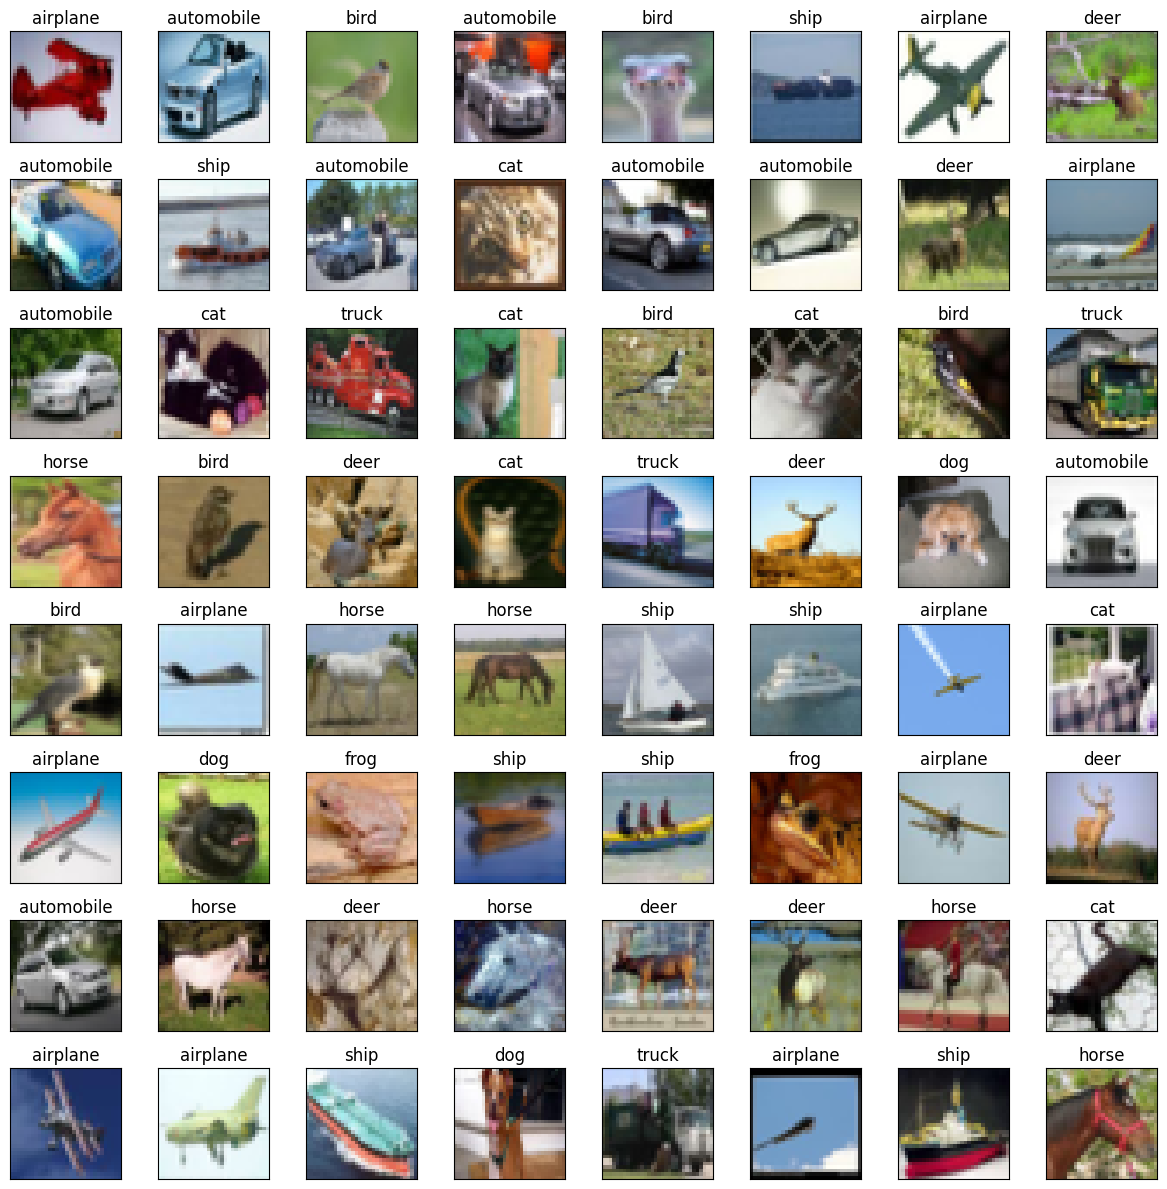

In [53]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Transform the current image images[idx] into a NumPy array
    # TODO
    img = images[idx].numpy()
    
    # Un-normalize the image
    # TODO
    img = img*0.5 + 0.5

    # Transpose image from C x H x W to H x W x C
    # Use np.transpose
    # TODO
    img = np.transpose(img, (1, 2, 0))
    
    plt.imshow(img)
    
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Convolutional Neural Network

Convolutional neural networks (CNNs) have been extremely succesfull in image classification tasks. Here we want to define such architecture by subclassing PyTorch's [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). A simple CNN architecture consists of a feature-detection part composed of 2D convolutional layers and pooling layers and a second classification part composed of fully connected layers.

*Define a simple convolutional neural network with the following characteristics:*
* _Three convolutional layers with `16`, `32`, and `64` output channels (use $3 \times 3$ kernels)_
* _Maximum pooling (with $2 \times 2$ kernel)_
* _Two fully connected layers (with an hidden dimesnion between the two layers of `512`_

*For simplicity, you can consider that the hard-coded batch size of `64` defined above does not change.*

*You will have to:*
  * _Choose the number of input channels (considering we are dealing with RGB images)_
  * _Choose appropriate values for the padding so that convolutions don't change the spatial dimensions of the image (or use `padding="same"`)_
  * _Determine the input size of the first linear layer_
  * _Determine the output size of the last linear layer_
  * _Drefine the `forward()` function_

The size of the convolutional and maximum pooling kernels, as well as the number of channels and fully connected layers are all hyperparameters of the model.

In [70]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Define layers with input_channel, output_channel, and kernel size
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        
        # TODO
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')

        # TODO
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')

        # TODO
        self.pool = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReLU())

        # TODO
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU())
            
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):

         # Input shape
        assert x.shape == (64, 3, 32, 32)

        # Apply first convolution and activation
        # TODO
        x = self.conv1(x)

        # First convolution goes from 3 to 16 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 16, 32, 32)

        # Apply pooling
        # TODO
        x = self.pool(x)

        assert x.shape == (64, 16, 16, 16)

        # Apply second convolution and activation
        # TODO
        x = self.conv2(x)

        # First convolution goes from 16 to 32 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 32, 16, 16)

        # Apply pooling
        # TODO
        x = self.pool(x)

        assert x.shape == (64, 32, 8, 8)

        # Apply third convolution and activation
        # TODO
        x = self.conv3(x)

        # First convolution goes from 32 to 64 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 64, 8, 8)

        # Apply pooling
        # TODO
        x = self.pool(x)

        assert x.shape == (64, 64, 4, 4)

        # Flatten features for fully connected layers
        x = x.view(-1, 64 * 4 * 4)

        assert x.shape == (64, 64 * 4 * 4)

        # Apply first fully connected layer and activation
        # TODO
        x = self.fc1(x)

        assert x.shape == (64, 512)

        # Apply second fully connected layer and log_softmax
        # TODO
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        assert x.shape == (64, 10)

        return x

In [69]:
64*4*4

1024

In the _forward_ function above, we have inserted many assetions to check that the shapes of the input and output tensors for each operation are as expected. *Make sure you understand how the dimesnions of the tensors change.*

We can finally create an instance of the CNN model, to be trained:

In [71]:
model = CNN()

### Training and Inference on GPUs

Using a graphical processing unit (GPU) can speed up training by several orders of magnitude. In PyTorch, it is very easy to take advantage of GPUs. We can define a `torch.device`, depending on the resources that are available:

In [72]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(device)

cuda


Once the device is defined, we can move the model to the device:

In [73]:
model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

If the device is the CPU, this call does nothing. If we move the model to the GPU instead, we will have to remember to move the data to the GPU as well during training and inference.

### Test Forward Pass

To check that the model definition works correctly, we can propagate on batch of images through the network. As mentioned above, it is important to move the data to the same device of the model.

To make the exercise a bit more interesting, we can show the class probabilities obtained from the forward pass of one batch of images with the un-trained model. We expect the prediction to be random, so a class probability around `0.1` for each of the 10 classes in the dataset. The following utility function can be used to show class probabilities:

*Implement the forward pass of a batch of images, and the computation of class probabilities given the model output. Remember: the model output is `log_softmax`, while class probabilities are given by `softmax`.*

In [78]:
def showclassp(images, labels, model, misclassified=False):
    """
    Plot class probabilities for a batch of images and labels.
    """
    
    from collections import namedtuple
    Misclassified = namedtuple("Misclassified", "idx label")
    
    fig = plt.figure(figsize=(14,12))
    
    failed = []
    
    with torch.no_grad():
            # Perform a forward pass of the batch of `images`
            # output of the model should be a (64, 10) for the batch size 64 and 10 classes
            out = model(images.to(0))
            
            # Compute class probabilities
            # TODO
            p = 10**out
            
            # Move the probability tensor to the CPU and convert to numpy array
            p = p.cpu().numpy()
    
    for idx in range(64):        
        ax = fig.add_subplot(8, 8, idx + 1, xticks=range(10), yticks=[0, 1])

        for i in range(10):
            if labels[idx] == i:
                if labels[idx] == np.argmax(p[idx]):
                    plt.bar(i, p[idx,i], color="g")
                else:
                    plt.bar(i, p[idx,i], color="r")
                    
                    failed.append(Misclassified(idx, np.argmax(p[idx])))
            else:
                plt.bar(i, p[idx,i], color="k")
        plt.ylim([0,1.25])
        
        ax.set_xticklabels(label_to_name.values(), rotation=90, fontdict={"fontsize": 7.5})
        
        name = label_to_name[labels[idx].item()]
        ax.set_title(name, fontdict={"fontsize": 12})

    plt.tight_layout()
    plt.show()
    
    return failed if misclassified else  None

A few important notes:
* During inference we don't need to compute gradients and therefore we can use the `torch.no_grad()` context manager
* Since the model outputs log probabilities, the actual probabilities are obtained through exponentiation 
* The predictions (`out`) need to be moved to the CPU, in case they have been obtained on the GPU

*Get a batch of training images (and labels) from `trainiter`, move the images and labels to the `device`, and use the utility function `showclassp` to show the class probabilities of the batch:*

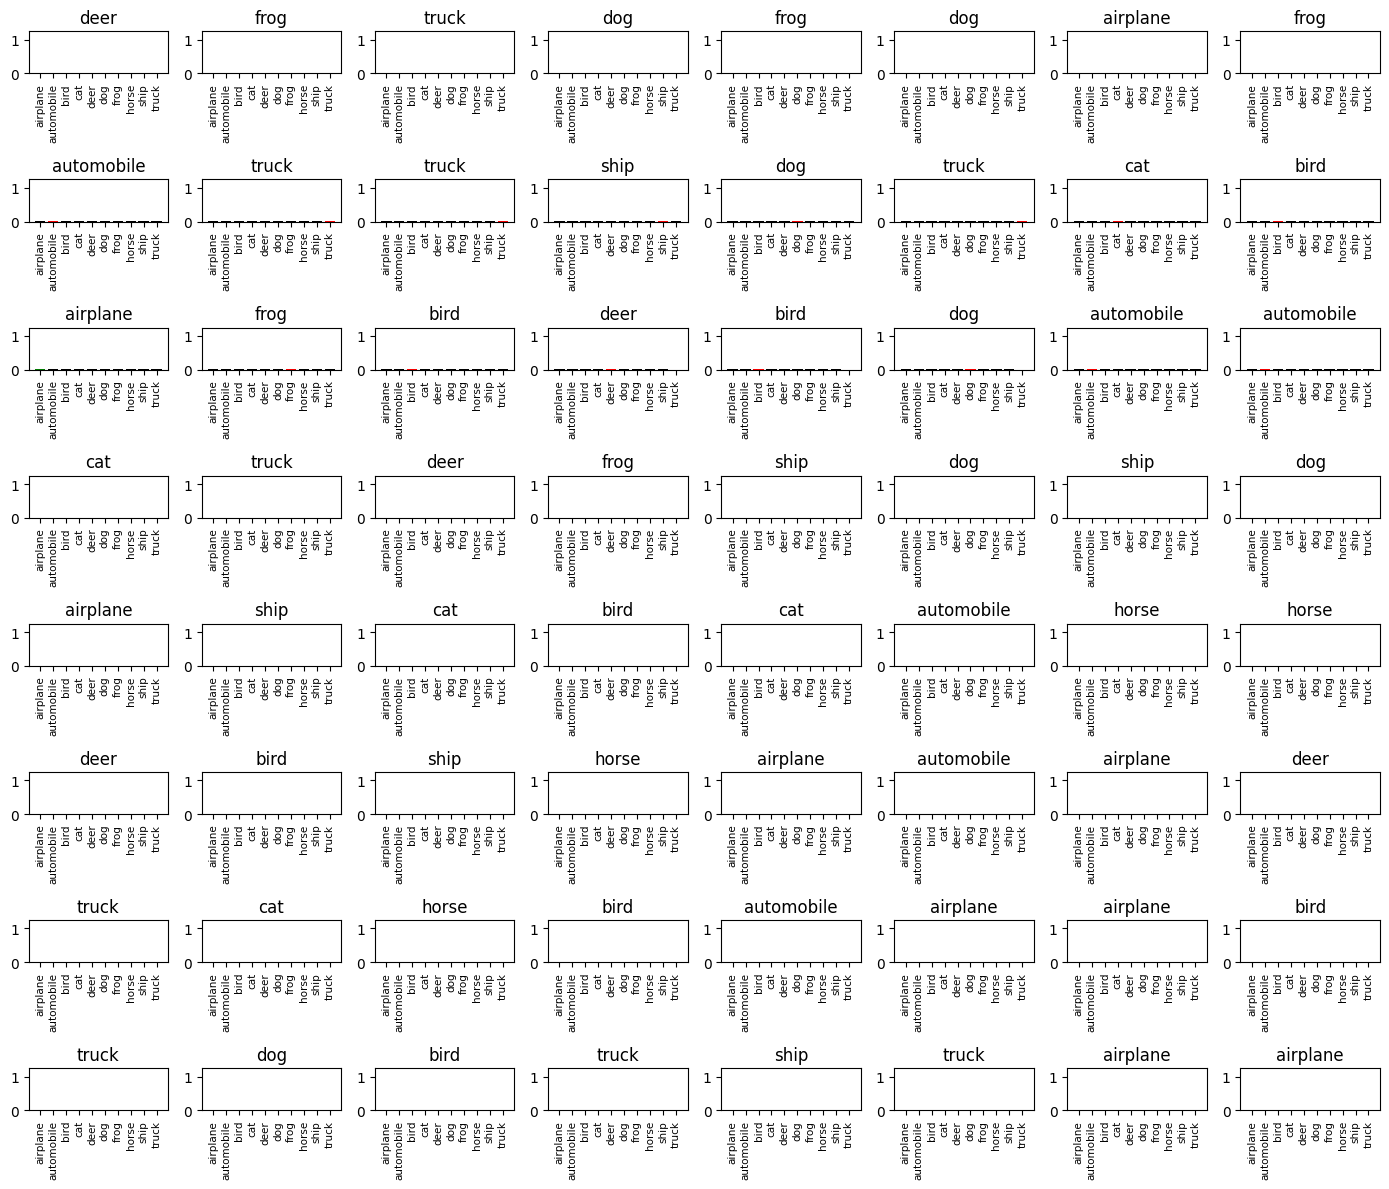

In [79]:
# Get a batch from `trainiter`
images, labels = next(trainiter)

# Move images and labels to the device
# TODO
images, labels = images.to(0), labels.to(0)

# Show class probabilities using the utility function defined above
showclassp(images, labels, model)

As expected, the class probabilities look pretty much the same for each class (uniform distribution) and are close to
$1/10$, since the parameters of the neural network are initialised at random. If everything seems to work as expected, we are ready to train the convolutional neural network for image classification!

## Training

In order to train the model we still have to define a loss function and select an optimizer. Since our model output passes through a `F.log_softmax`function, we need to use a negative log-likelihood loss:

In [80]:
nll_loss = nn.NLLLoss()

This is equivalent to applying the `CrossEntropyLoss` to the raw output of `nn.Linear`.

For the optimizer, we use the widely used [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

*Define an `Adam` optimizer with a learning rate of `0.003`. Remember that you have to pass the model's parameters to the optimizer.*

In [81]:
# TODO
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Note that the optrimizer needs to know about the model parameters. During training, the model parameters are adjusted by the optimizer in order to reduce the loss on the training set. The learning rate `lr` is another hyperparameter of the model.

*Implement the missing bits in  training loop (identified by `TODO` comments):*
* _Move data (images and labels) from the CPU to the `device`_
* _Reset gradients of the optimizer_
* _Perform forward pass_
* _Compute the loss_
* _Perform bakcpropagation_
* _Update the weights of the model using the optimizer_

In [86]:
def train(model, optimizer, loss_function, epochs, device):
    import time

    # Ensure the model is running on the device
    model.to(device)

    train_losses, valid_losses, accuracies = [], [], []

    pbar = trange(epochs, desc='Training', leave=True)
    for epoch in pbar:
        
        epoch_loss = 0
        
        # Train the model for one epoch
        for images, labels in trainloader:

            # Move data to GPU
            # TODO
            images, labels = images.to(0), labels.to(0)
        
            # Reset optimizer gradients to zero
            # TODO
            optimizer.zero_grad()
            
            # Perform forward pass
            # TODO
            output = model(images)
            
            # Compute the loss
            # TODO
            loss = nll_loss(output, labels)
            
            # Perform backpropagation
            # TODO
            loss.backward()
            
            # Update model weights
            # TODO
            optimizer.step()
            
            epoch_loss += loss.detach().item()
        
        # Evalutate the model on the validation set
        valid_loss = 0
        accuracy = 0

        with torch.no_grad(): 
            for images, labels in validloader:

                # Move data to GPU
                # TODO
                images, labels = images.to(0), labels.to(0)
                    
                # Perform forward pass
                # TODO
                output = model(images)
                    
                # Accumulate the validation loss
                valid_loss += loss_function(output, labels).item()
                    
                # Compute class probabilities
                # TODO
                p = 10**output
                
                # Compute accuracy
                top_p, top_c = p.topk(1, dim=1) # Top prediction
                equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)
                accuracy += torch.mean(equals)
                    
        train_losses.append(epoch_loss/len(trainloader))
        valid_losses.append(valid_loss/len(validloader))
        accuracies.append(accuracy.item()/len(validloader)*100)
        
        pbar.set_postfix({"Accuracy": accuracies[-1]})
    
    return train_losses, valid_losses, accuracies

In [87]:
train_losses, valid_losses, accuracies = train(model, optimizer, nll_loss, epochs=15, device=device)

Training: 100%|██████████| 15/15 [01:00<00:00,  4.06s/it, Accuracy=58.4]


Once training is finished we can plot the loss of both the training and the validation sets as a function of the epoch:

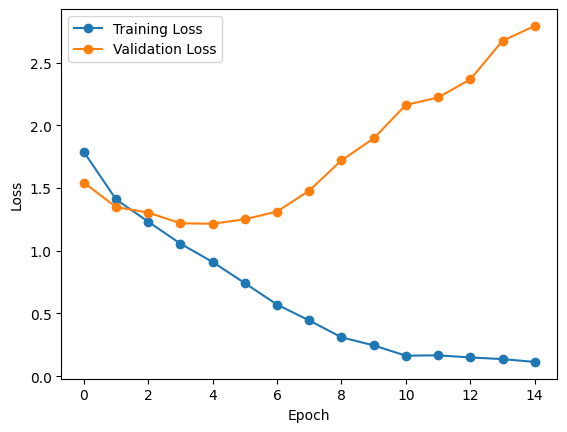

In [88]:
fig = plt.figure()
plt.plot(train_losses, "o-", label="Training Loss")
plt.plot(valid_losses, "o-", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.pdf")
plt.savefig("loss.png")
plt.show()

We see that the validation loss decreases at first but then it starts increasing. This is caused by over-fitting: the model starts to become well tuned for the training set (as shown by the decreasing training loss) but fails to generalise to the new samples contained in the validation set. There are several techniques to deal with over-fitting, which we will see later on.

## Evaluation of Trained Model

### Class Probabilities and Misclassified Examples

With our trained model, we can visualise the class probabilities and predicitons for one batch of the test set:

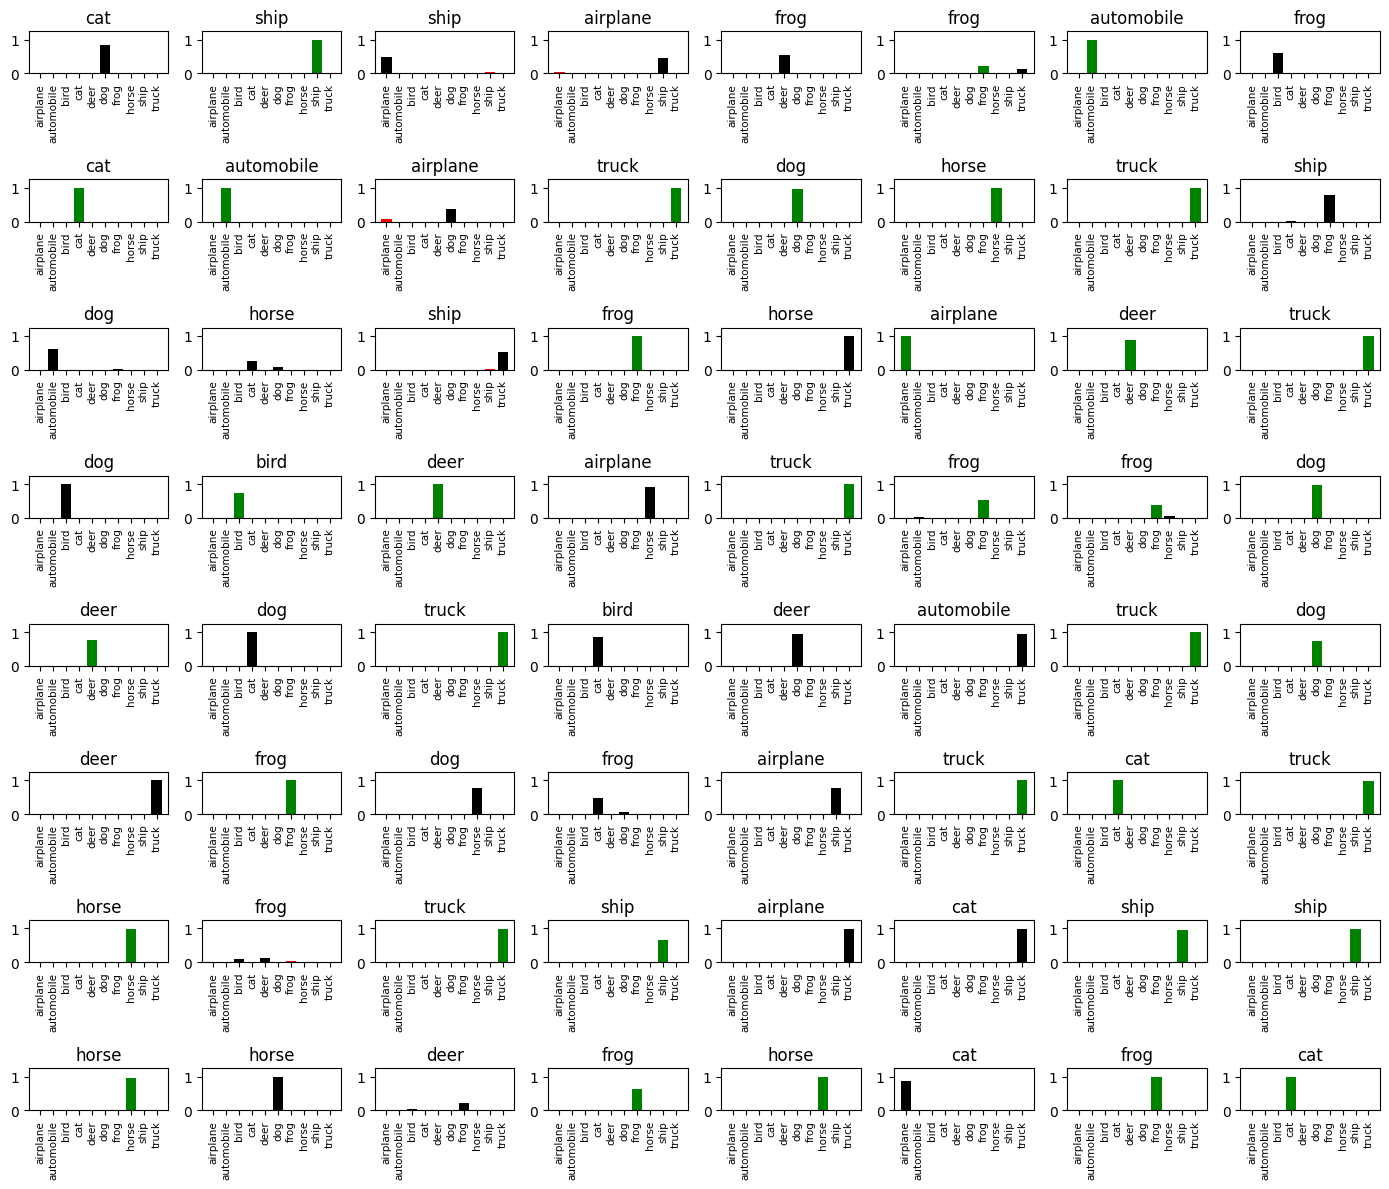

In [89]:
images, labels = next(testiter)
images, labels = images.to(device), labels.to(device)

misclassified = showclassp(images, labels, model, misclassified=True)

We can see that the class probabilities are no longer uniform, and in several cases the model prediction is correct. We can finally predict the classes of all images in the test set.

Let's plot the misclassified examples of this batch:

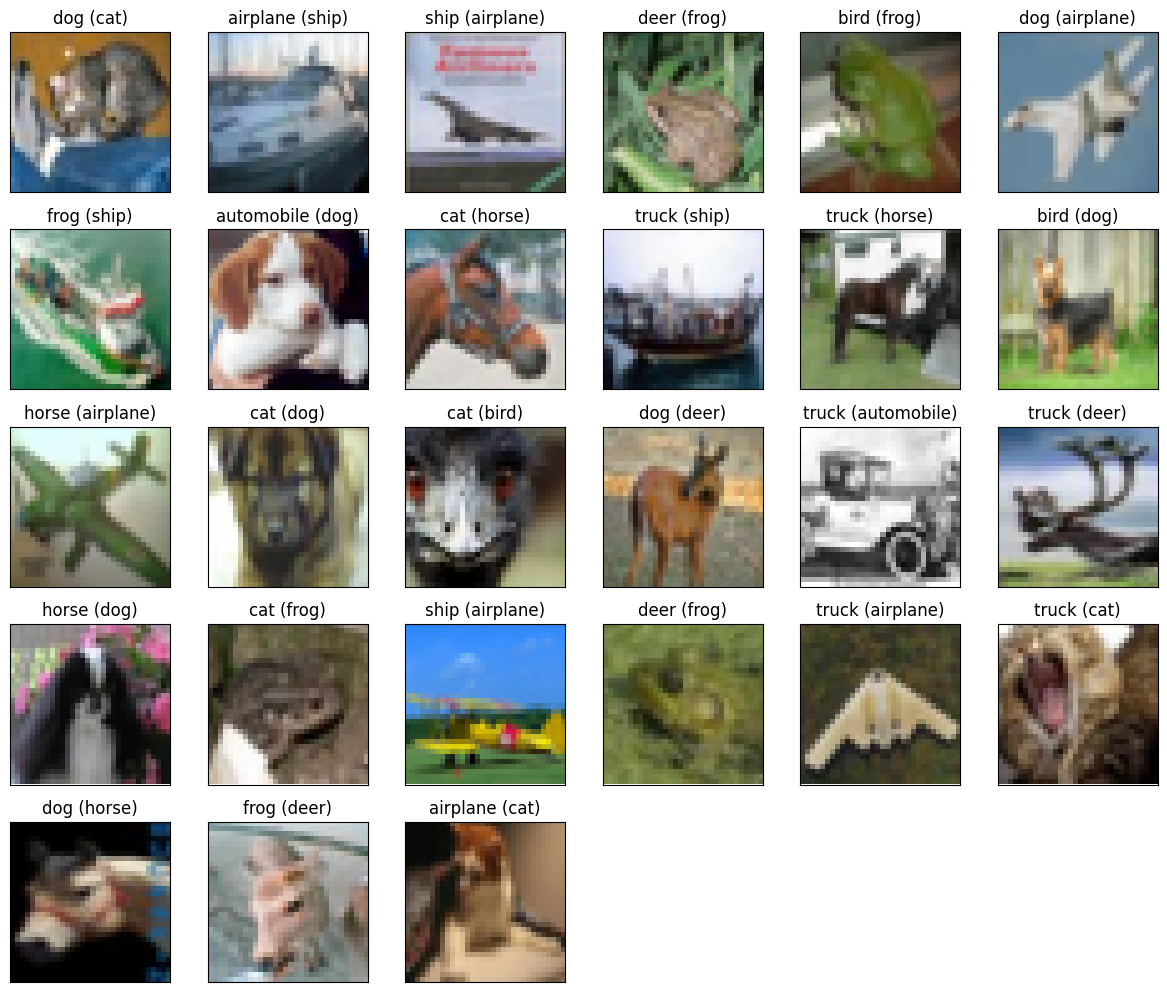

In [90]:
n = int(np.ceil(np.sqrt(len(misclassified))))

fig = plt.figure(figsize=(12,12))

for i, (idx, label) in enumerate(misclassified):
    ax = fig.add_subplot(n, n, i + 1, xticks=[], yticks=[])
    
    img = images[idx].cpu().numpy().squeeze() * 0.5 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))    
    
    name = label_to_name[label]
    true_name = label_to_name[labels[idx].item()]
    
    ax.set_title(f"{name} ({true_name})", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

*Comment on the misclassified examples.*

*Complete the missing steps (`TODO`s) needed to obtained the predicted labels and the ground truth for the whole of the test set.*

In [91]:
def predict(model, testloader):
    n = len(testloader) * 64
    
    y_pred = np.zeros(n)
    y_true =np.zeros(n)
    
    i = 0
    
    model.eval()
    
    with torch.no_grad(): 
        for images, labels in testloader:

            # Move data to GPU
            # TODO
            images, labels = images.to(0), labels.to(0)
                
            # Perform forward pass
            # TODO
            output = model(images)
                
            # Compute class probabilities
            # TODO
            p = 10**output
                
            # Get class of top prediction
            p, c = torch.max(p, dim=1)
            
            y_pred[i*64:i*64+64] = c.cpu().numpy()
            y_true[i*64:i*64+64] = labels.cpu().numpy()
            
            i += 1
            
    assert i == len(testloader)
    
    return y_pred, y_true

In [92]:
l_pred, l_true = predict(model, testloader)

### Confusion Matrix

The confusion matrix allows to assess the quality of a multi-class classifier and spot patterns in misclassified examples. To compute the confusion matrix we can predict the classes of our test set with the trained model and use `sklearn.metrics.confusion_matrix` to get the confusion matrix:

In [93]:
C = metrics.confusion_matrix(l_pred, l_true)

C100 = np.zeros(C.shape)
for idx in range(10):
    C100[idx,:] = C[idx,:] / np.sum(C[:, idx]) * 100

Let's visualize the confusion matrix:

Text(0, 0.5, 'True Label')

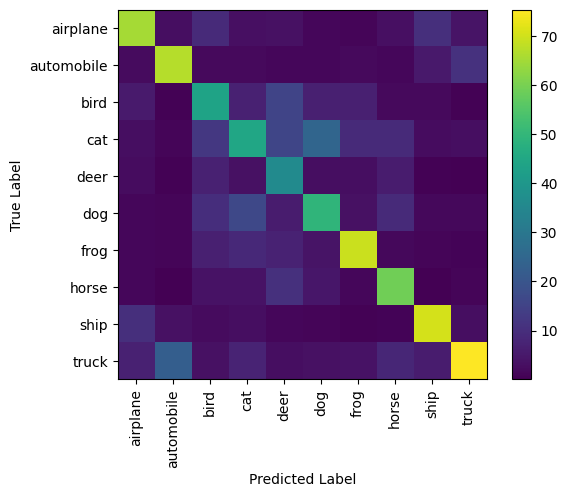

In [94]:
plt.imshow(C100)
plt.xticks(range(10), label_to_name.values(), rotation=90)
plt.yticks(range(10), label_to_name.values())
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

*Comment on the results.*

### Accuracy

From the confusion matrix, we can compute the per-class accuracy:

In [95]:
for idx in range(10):
    correct_predictions = C[idx, idx]
    total_predictions = np.sum(C[:, idx])
    a = correct_predictions / total_predictions
    print(f"{label_to_name[idx]:<15}{round(a * 100, 2)}%\t({correct_predictions:>3}/{total_predictions:>4})") 

airplane       65.03%	(649/ 998)
automobile     66.97%	(669/ 999)
bird           43.74%	(437/ 999)
cat            44.63%	(445/ 997)
deer           36.2%	(362/1000)
dog            49.25%	(491/ 997)
frog           69.2%	(692/1000)
horse          58.88%	(587/ 997)
ship           70.41%	(702/ 997)
truck          75.3%	(753/1000)


*Why some classes have less than 1000 examples in the test set?*

We can see that the accuracy is very good for some classes, but not so good for others. This was already reflected in confusion matrix, where cats and dogs are often confused. The missing samples are due to the use of `drop_last=True`.

The total accuracy is given by

In [96]:
metrics.accuracy_score(l_pred, l_true)

0.5796274038461539

Not great, not terrible.

*Comment on the overall accuracy of the model. Can we achieve a better result than this one?*